<a href="https://colab.research.google.com/github/seismomat/IBEM/blob/Lili/IBEM_General.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Programa general:

In [2]:
#Se importan bibliotecas:
import math
import scipy.special as scis
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt

In [3]:
#Geometría del problema
L=10000 #m Longitud

#Parḿetros del problema
#Periodo
T=2 #s
#Frecuencia fundamental
f0=1/T #1/s
#Diferencial de tiempo
dt=0.05 #s
#Número de frecuencias
N=64
#Frecuencia máxima
fmax=1/(2*dt)
#Diferencial de frecuencia
df=1/((N)*dt)

#Vector de frecuencias
f = np.arange(df, fmax, df)
#Vector de frecuencia angular
w = 2*np.pi*f

#Velocidad
beta=2500
#Densidad
rho=2500

#Vector de longitud de onda
lambd = beta/f
#Vector de número de onda
k = w / beta

#f0,fmax,df

#Puntos por longitud de onda
NP=16

#Vector distancia entre segmentos para cada lambda/NP
dx=lambd/NP

#Ubicación de la fuente
Fuente=np.array([5000,-10])



In [4]:
print(len(f))

31


In [5]:
#prueba=segmentos(L,dx[1])
#print(prueba[0])

In [6]:
#FUNCION PARA CREAR LOS SEGMENTOS PARA CADA LONGITUD DE ONDA:
def segmentos(L,dx):
  # Variables de entrada:
  #  L: longitud total
  #  dx: longitud del segmento

  #Se obtiene número de segmentos
  ns=L/dx

  #Se crea vector con coordenadas de los segmentos
  segmento=np.zeros((int(ns)+1,2))
  segmento[:,0]=np.linspace(0,L,int(ns)+1)

  #Se obtienen la distancia para definir puntos medios:
  dxp=segmento[1,0]-segmento[0,0]

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp=np.zeros((int(ns),2))
  xp[:,0]=segmento[:-1,0]+dxp/2
  #Regresa vectores de coordenadas de segmentos, puntos medios y número de segmentos
  return segmento, xp, ns

In [7]:
#FUNCIÓN DE VECTORES NORMALES:
def normales(segmento):
  #Variables de entrada:
  #   segmento: vector de coordenadas

  #Se obtienen vectores normales:
  AB=segmento[1:]-segmento[:-1] #Diferencia
  nor=AB[:,0] #Para obtener unitario
  normal=AB*0 #Auxiliar
  #Vector normal invirtiendo coordenadas y signo
  normal[:,0]=-AB[:,1]/nor
  normal[:,1]=AB[:,0]/nor
  #Regresa vectores normales de los segmentos
  return normal

In [8]:
#Esta es una prueba de qye funcionaban las funciones anteriores:
'''
segmento, xp, ns=segmentos(L,dx[0])
normal=normales(segmento)
plt.plot(segmento[:,0],segmento[:,1],marker = '|')
plt.plot(xp[0:int(ns),0],xp[0:int(ns),1],'o')
plt.plot(Fuente[0],Fuente[1],marker = '*')

plt.xlabel('Distancia x')

plt.show()

print(normal)
'''

"\nsegmento, xp, ns=segmentos(L,dx[0])\nnormal=normales(segmento)\nplt.plot(segmento[:,0],segmento[:,1],marker = '|')\nplt.plot(xp[0:int(ns),0],xp[0:int(ns),1],'o')\nplt.plot(Fuente[0],Fuente[1],marker = '*')\n\nplt.xlabel('Distancia x')\n\nplt.show()\n\nprint(normal)\n"

In [9]:
#Función T22:
def T22(k,x,xi,normal):
  # Variables de entrada:
  # k: número de onda
  # x: Punto sobre el que se calculan las contribuciones de los otros segmentos (vector)
  # xi: Punto correspondiente al otro segmento (vector)
  # normal: vector normal
    #Se obtiene norma
    r= la.norm(x-xi)
    #Se calcula función de hankel
    D = k*r * scis.hankel2(1,k*r)
    #Producto punto entre vector normal y gamma
    g_n=(x[0]-xi[0])/r * normal[0] + (x[1]-xi[1])/r * normal[1]
    #Regresa la función T22
    return 1j/(4*r) * D * g_n

#Función G22:
def G22(k,x,xi,beta,rho):
    r=la.norm(x-xi)
    H=scis.hankel2(0,k*r)
    return (1/(1j*4*rho)) * (H/(beta**2))

#Integración Gaussiana de T22
def Int_T22(n,l,k,segmento,xp,normal):
  #Variables de entrada:
  # n: índice de x
  # l: índice de xi
  # segmento: Vector de segmentos
  # xp: vector de puntos medios entre segmentos
  # normal: vector normal

    #Para 5 puntos:
    nodos = [-0.906179845938664, -0.538469310105683,0, 0.538469310105683, 0.906179845938664]
    pesos = [0.236926885056189, 0.478628670499366, 0.568888888888889, 0.478628670499366, 0.236926885056189]

    #Para x (Horizontal)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,0]
    a=segmento[l+1,0]
    xix_nodo = []  # Crear una lista vacía para almacenar los resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xix_nodo.append(resultado) #Mete resultado a la lista

    #Para z (Vertical)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,1]
    a=segmento[l+1,1]
    xiz_nodo = [] #Lista vacía para almacenar resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xiz_nodo.append(resultado) #Mete resultado a la lista

    Xi_nodo = []  # Crear una lista vacía para almacenar las listas
    for i in range(len(nodos)):
      sublista = [xix_nodo[i], xiz_nodo[i]]  # Crea la sublista con nodos en x y z
      Xi_nodo.append(sublista)  # Agrega la sublista a la lista

    Xi_nodo = np.array(Xi_nodo) #Convierte lista a arreglo np, porque no funcionaba xD

    #Calcula distancia entre segmentos
    L=la.norm(segmento[l]-segmento[n])
    Int=0.0 #Variabke auxuliar para almacenar resultado de integral
    for i in range(len(nodos)):
        #Se calcula integral llamando a función T22 con los nodos
        Int += L/2 * pesos[i]*T22(k,xp[n],Xi_nodo[i],normal[n])
    #Regresa integral
    return Int

    #Integración Gaussiana de G22
def Int_G22(n,l,k,segmento,xp,normal):
  #Variables de entrada:
  # n: índice de x
  # l: índice de xi
  # segmento: Vector de segmentos
  # xp: vector de puntos medios entre segmentos
  # normal: vector normal

    #Para 5 puntos:
    nodos = [-0.906179845938664, -0.538469310105683,0, 0.538469310105683, 0.906179845938664]
    pesos = [0.236926885056189, 0.478628670499366, 0.568888888888889, 0.478628670499366, 0.236926885056189]

    #Para x (Horizontal)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,0]
    a=segmento[l+1,0]
    xix_nodo = []  # Crear una lista vacía para almacenar los resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xix_nodo.append(resultado) #Mete resultado a la lista

    #Para z (Vertical)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,1]
    a=segmento[l+1,1]
    xiz_nodo = [] #Lista vacía para almacenar resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xiz_nodo.append(resultado) #Mete resultado a la lista

    Xi_nodo = []  # Crear una lista vacía para almacenar las listas
    for i in range(len(nodos)):
      sublista = [xix_nodo[i], xiz_nodo[i]]  # Crea la sublista con nodos en x y z
      Xi_nodo.append(sublista)  # Agrega la sublista a la lista

    Xi_nodo = np.array(Xi_nodo) #Convierte lista a arreglo np, porque no funcionaba xD

    #Calcula distancia entre segmentos

    L=la.norm(segmento[l]-xp[n])
    Int=0.0 #Variabke auxuliar para almacenar resultado de integral
    for i in range(len(nodos)):
        #Se calcula integral llamando a función T22 con los nodos
        Int += L/2 * pesos[i]*G22(k,xp[n],Xi_nodo[i],beta,rho)
    #Regresa integral
    return Int

In [10]:
#Construcción de matriz de tracciones para cada frecuencia:
MGeneral=[] #Variable auxiliar vacía

for i in range(len(f)): #Repite el procedimiento para cada frecuencia
  #Obtiene distribución de segmentos para cada longitud de onda (dx)
  segmento, xp, ns=segmentos(L,dx[i])
  #Obtiene vector normal para los segmentos obtenidos
  normal=normales(segmento)
  #Construye matriz para cada frecuencia
  M22=np.zeros([int(ns),int(ns)])
  #Le pone su parte imaginaria
  M22 = M22 + 0j*M22
  #Se construye matriz
  for n in range(int(ns)):
      for l in range(int(ns)):
          if n==l:
              M22[n,l]=0.5+0j
          else:
              M22[n,l]=Int_T22(n,l,k[i],segmento,xp,normal)
  #Se mete a la matriz obtenida para una frecuencia en la variable auxiliar
  MGeneral.append(M22)
  print('Frecuencia %d : %f'%(i+1,f[i]))
#print(M22)

Frecuencia 1 : 0.312500
Frecuencia 2 : 0.625000
Frecuencia 3 : 0.937500
Frecuencia 4 : 1.250000
Frecuencia 5 : 1.562500
Frecuencia 6 : 1.875000
Frecuencia 7 : 2.187500
Frecuencia 8 : 2.500000
Frecuencia 9 : 2.812500
Frecuencia 10 : 3.125000
Frecuencia 11 : 3.437500
Frecuencia 12 : 3.750000
Frecuencia 13 : 4.062500
Frecuencia 14 : 4.375000
Frecuencia 15 : 4.687500
Frecuencia 16 : 5.000000
Frecuencia 17 : 5.312500
Frecuencia 18 : 5.625000
Frecuencia 19 : 5.937500
Frecuencia 20 : 6.250000
Frecuencia 21 : 6.562500
Frecuencia 22 : 6.875000
Frecuencia 23 : 7.187500
Frecuencia 24 : 7.500000
Frecuencia 25 : 7.812500
Frecuencia 26 : 8.125000
Frecuencia 27 : 8.437500
Frecuencia 28 : 8.750000
Frecuencia 29 : 9.062500
Frecuencia 30 : 9.375000
Frecuencia 31 : 9.687500


In [11]:
#Fuente para cada frecuencia

TG=[] #Variable auxiliar
#Se construye a la fuente para cada frecuencia definida
for i in range(len(f)):
  #Se obtiene distribución de segmentos para cada frecuencia
  segmento, xp, ns=segmentos(L,dx[i])
  #Se obtiene vector normal para cada segmento
  normal=normales(segmento)
  #Se define a la fuente y su parte compleja
  t2=np.zeros([int(ns),1])
  t2 = t2 + 0j*t2
  #Se calcula la fuente
  for l in range(int(ns)):
      t2[l]=-T22(k[i], xp[l], Fuente, normal[l])
  #Se almacena el resultado de cada frecuencia en variable auxiliar
  TG.append(t2)
  print('Frecuencia %d: %f'%(i+1,f[i]))

Frecuencia 1: 0.312500
Frecuencia 2: 0.625000
Frecuencia 3: 0.937500
Frecuencia 4: 1.250000
Frecuencia 5: 1.562500
Frecuencia 6: 1.875000
Frecuencia 7: 2.187500
Frecuencia 8: 2.500000
Frecuencia 9: 2.812500
Frecuencia 10: 3.125000
Frecuencia 11: 3.437500
Frecuencia 12: 3.750000
Frecuencia 13: 4.062500
Frecuencia 14: 4.375000
Frecuencia 15: 4.687500
Frecuencia 16: 5.000000
Frecuencia 17: 5.312500
Frecuencia 18: 5.625000
Frecuencia 19: 5.937500
Frecuencia 20: 6.250000
Frecuencia 21: 6.562500
Frecuencia 22: 6.875000
Frecuencia 23: 7.187500
Frecuencia 24: 7.500000
Frecuencia 25: 7.812500
Frecuencia 26: 8.125000
Frecuencia 27: 8.437500
Frecuencia 28: 8.750000
Frecuencia 29: 9.062500
Frecuencia 30: 9.375000
Frecuencia 31: 9.687500


In [12]:
len(TG)

31

In [13]:
#Resolviendo el sistema para cada frecuencia
solucionG=[] #Variable auxiliar
#Se obtiene solución para cada frecuencia
for i in range(len(f)):
  solucion = np.linalg.solve(MGeneral[i],TG[i])
  #Se almacena solución en variable auxiliar
  solucionG.append(solucion)
  print('Frecuencia %d: %f'%(i+1,f[i]))

Frecuencia 1: 0.312500
Frecuencia 2: 0.625000
Frecuencia 3: 0.937500
Frecuencia 4: 1.250000
Frecuencia 5: 1.562500
Frecuencia 6: 1.875000
Frecuencia 7: 2.187500
Frecuencia 8: 2.500000
Frecuencia 9: 2.812500
Frecuencia 10: 3.125000
Frecuencia 11: 3.437500
Frecuencia 12: 3.750000
Frecuencia 13: 4.062500
Frecuencia 14: 4.375000
Frecuencia 15: 4.687500
Frecuencia 16: 5.000000
Frecuencia 17: 5.312500
Frecuencia 18: 5.625000
Frecuencia 19: 5.937500
Frecuencia 20: 6.250000
Frecuencia 21: 6.562500
Frecuencia 22: 6.875000
Frecuencia 23: 7.187500
Frecuencia 24: 7.500000
Frecuencia 25: 7.812500
Frecuencia 26: 8.125000
Frecuencia 27: 8.437500
Frecuencia 28: 8.750000
Frecuencia 29: 9.062500
Frecuencia 30: 9.375000
Frecuencia 31: 9.687500


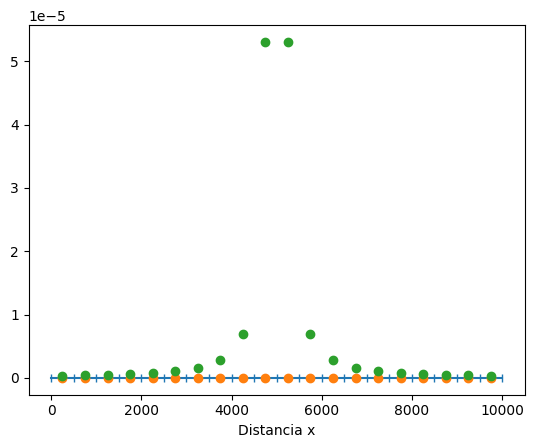

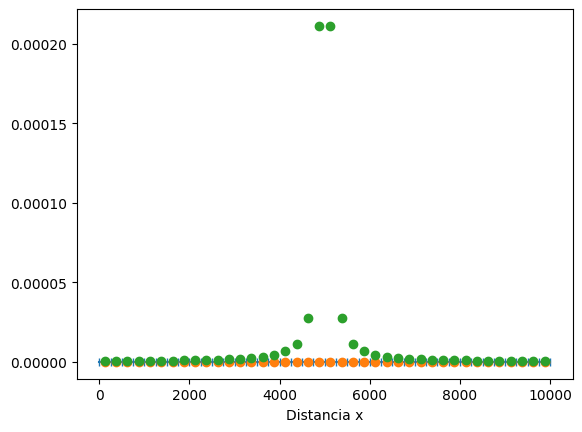

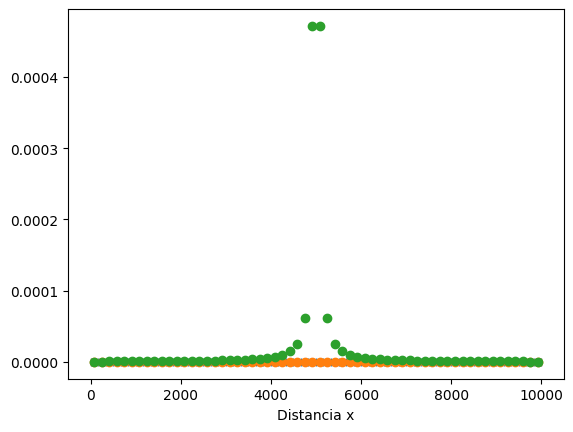

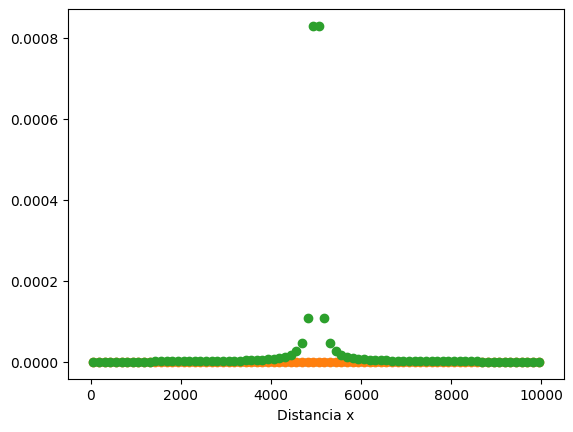

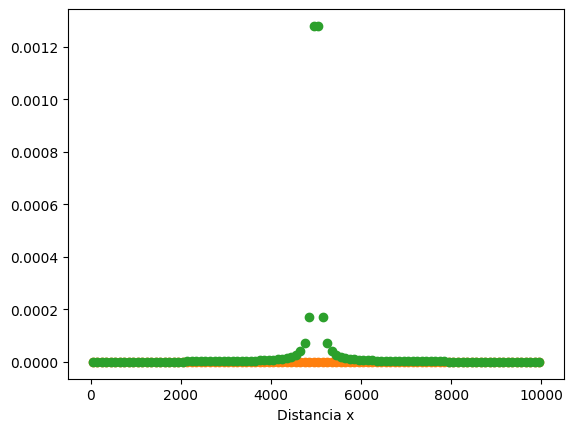

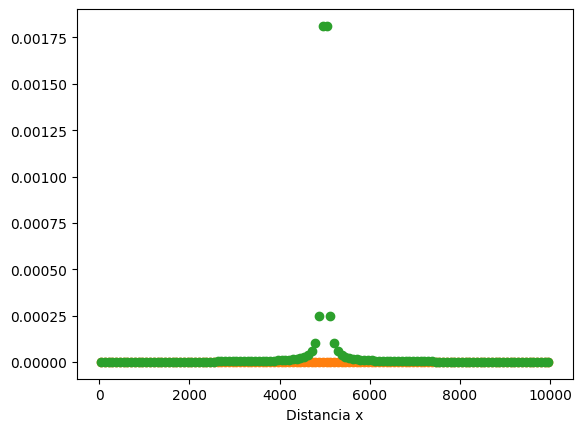

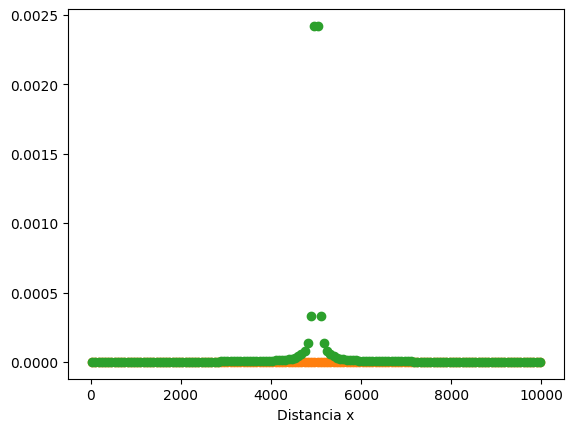

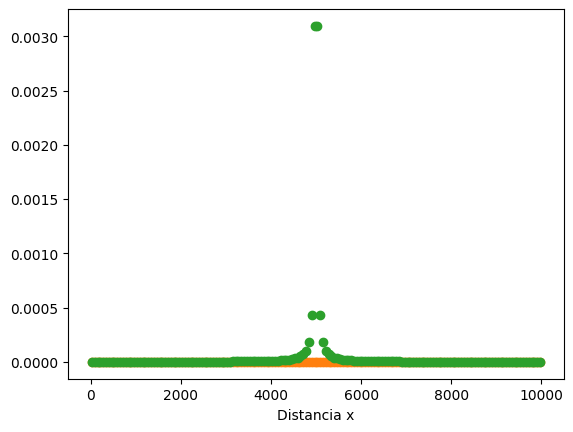

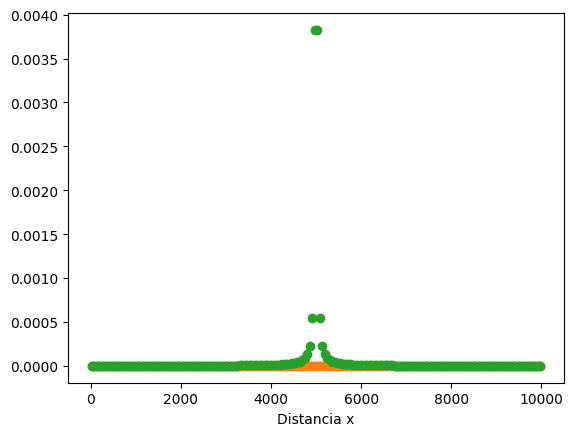

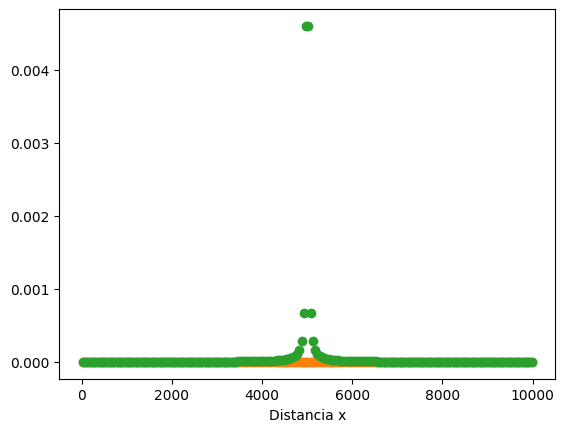

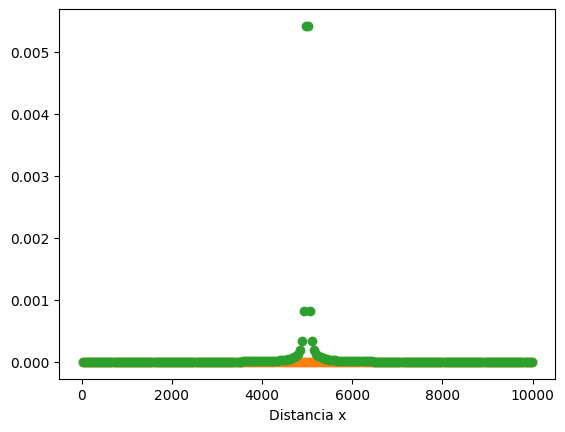

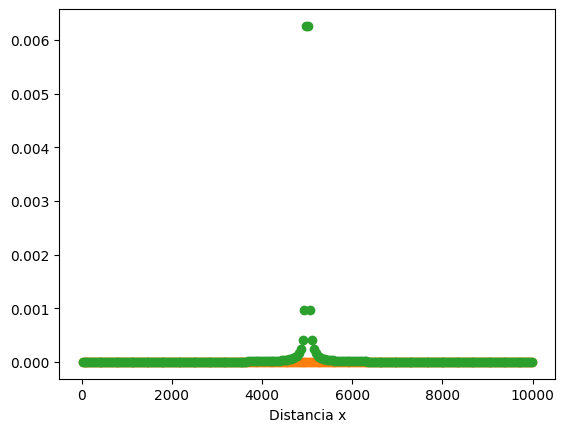

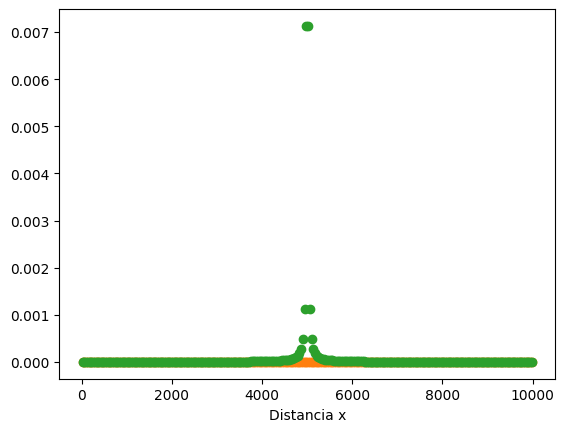

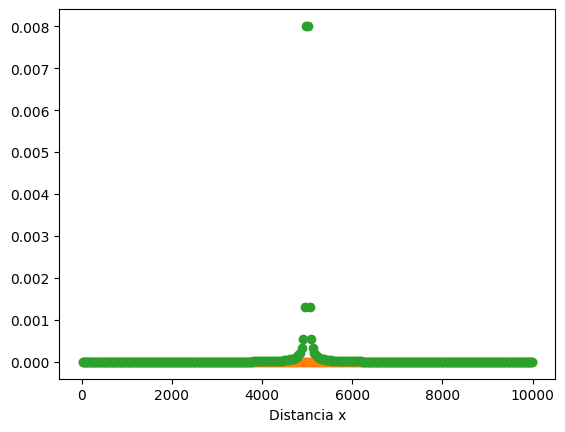

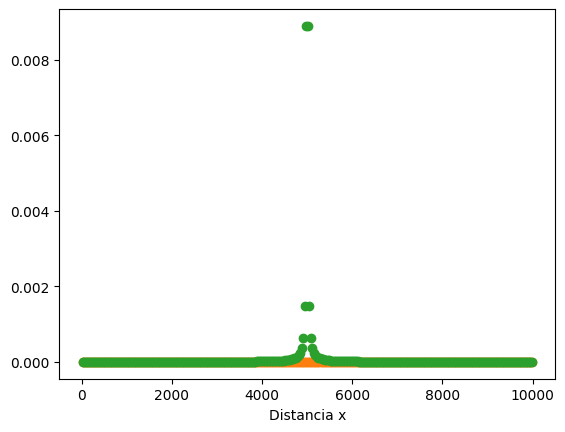

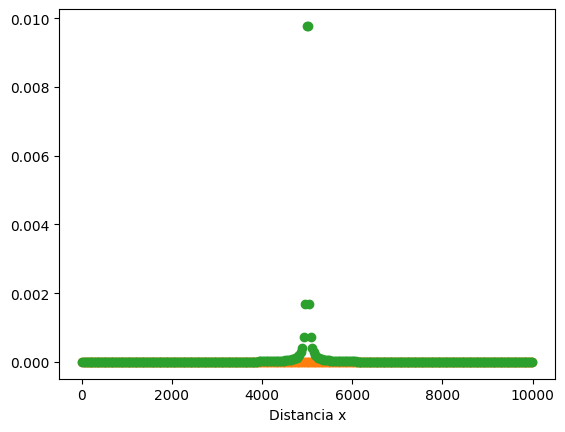

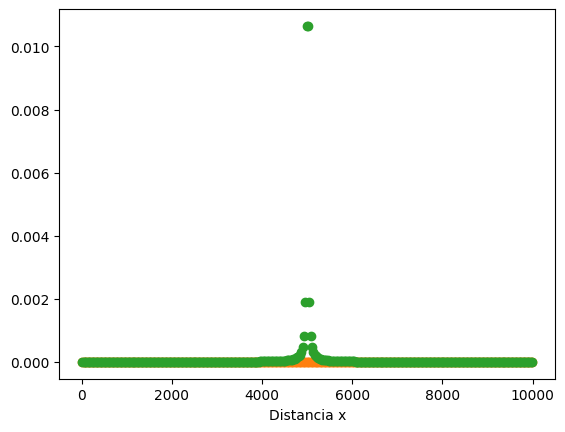

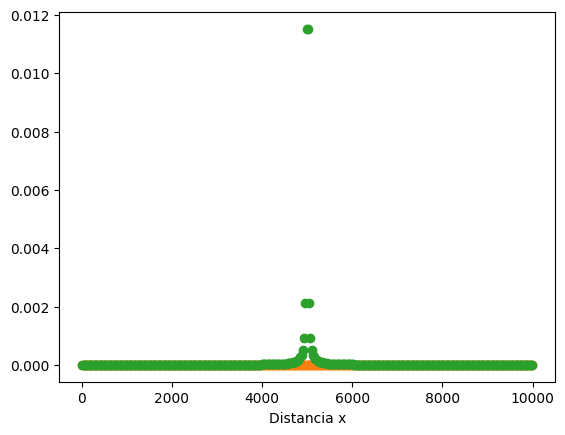

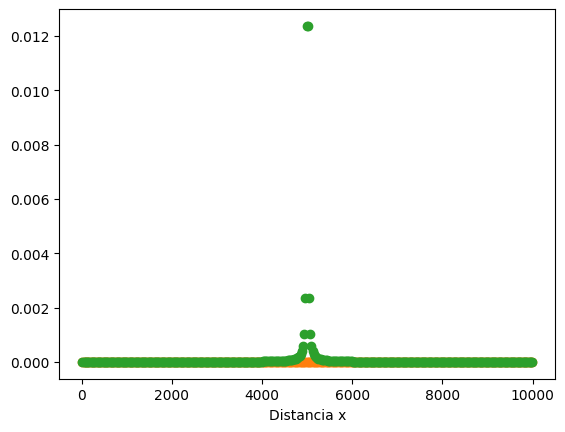

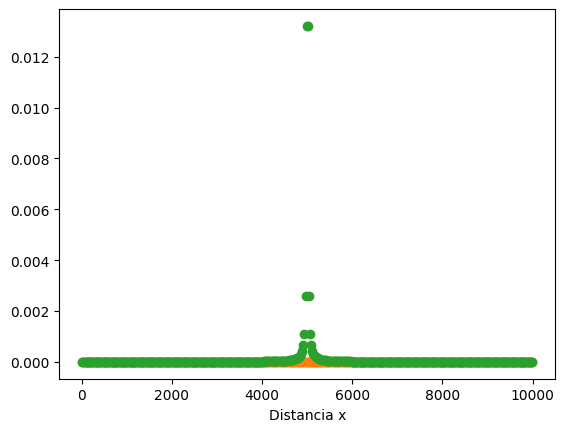

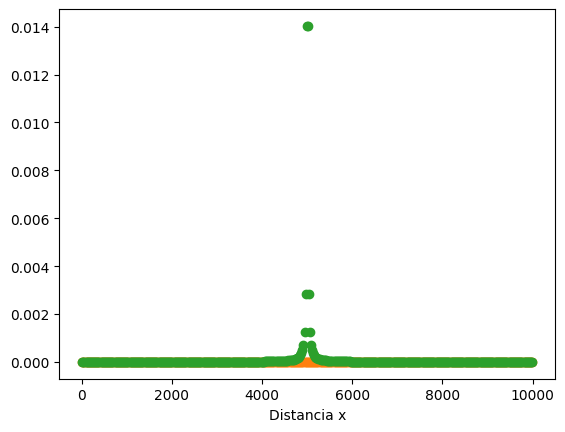

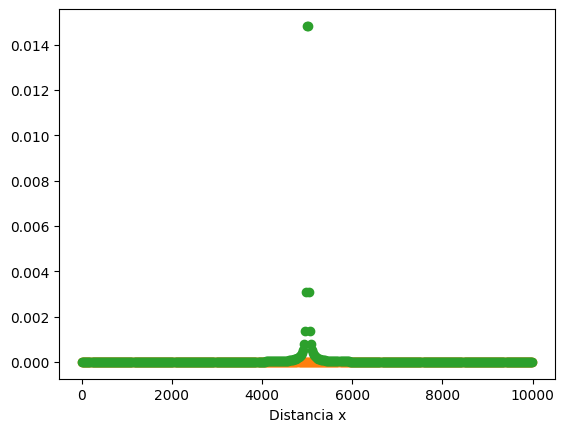

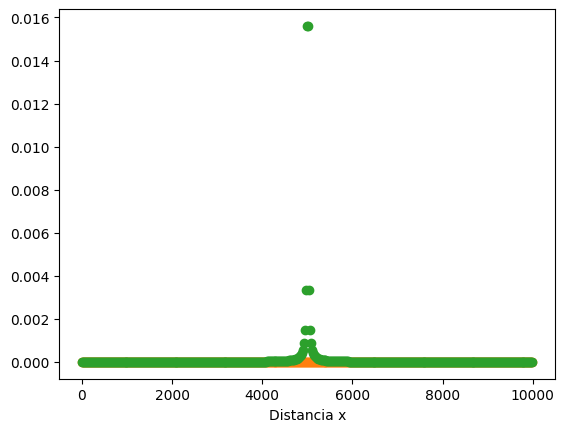

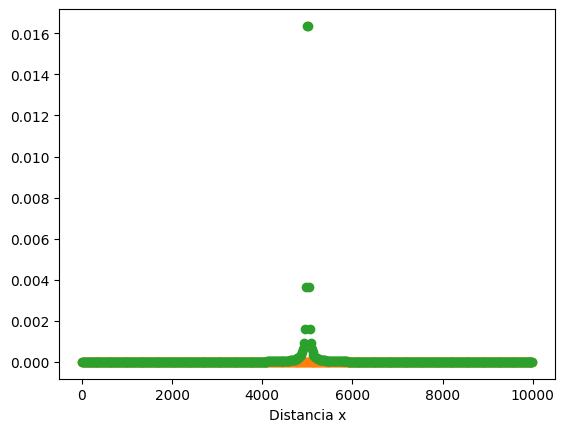

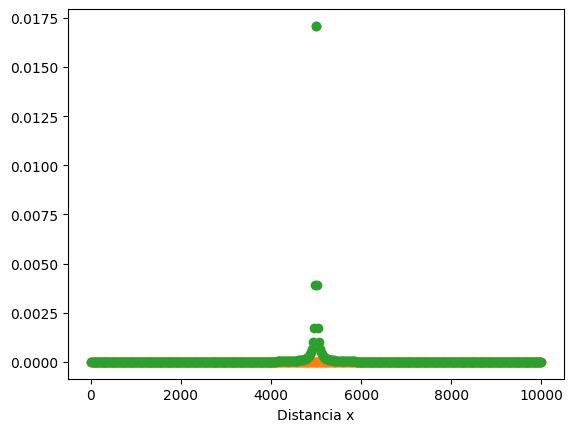

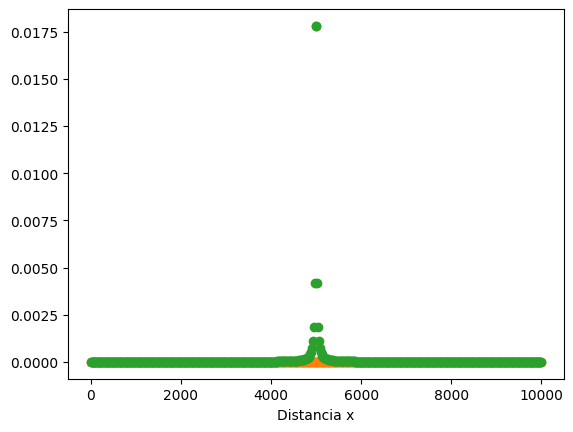

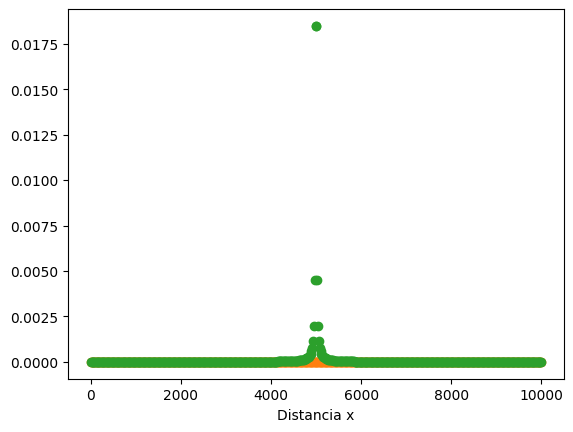

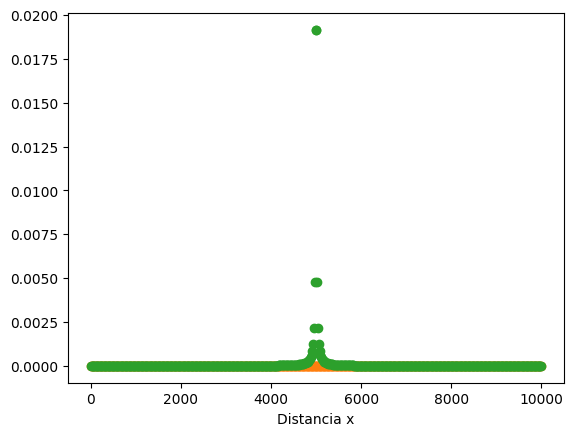

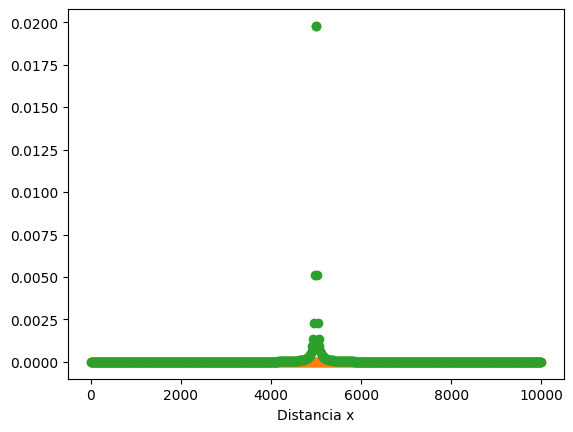

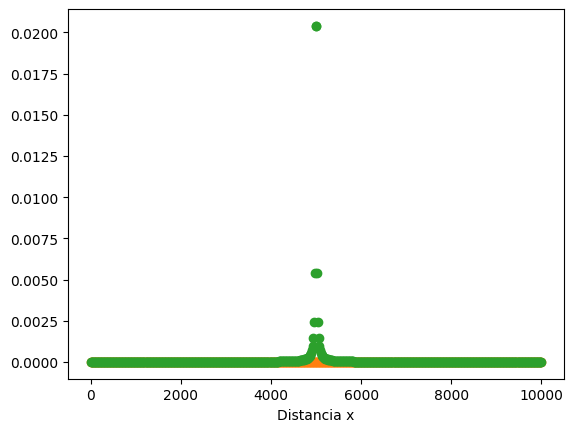

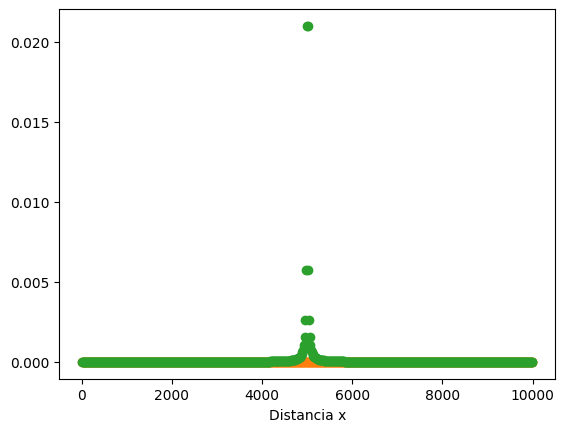

In [14]:
#Graficas para cada frecuencia:

for i in range(len(f)):
  segmento, xp, ns=segmentos(L,dx[i])
  normal=normales(segmento)
  plt.plot(segmento[:,0],segmento[:,1],marker = '|')
  plt.plot(xp[0:int(ns),0],xp[0:int(ns),1],'o')
  plt.plot(xp[0:int(ns),0],np.abs(solucionG[i]),'o')
  #plt.plot(Fuente[0],Fuente[1],marker = '*')

  plt.xlabel('Distancia x')

  plt.show()

In [15]:
'''
#Calculando los desplazamientos:
punto=np.array([5000,0])
nlen=len(punto)
print(nlen)

#Construcción de matriz Green:
#n=0
#l=0
#PRUEBA=Int_G22(n,l,k,segmento,punto,normal)
#print(PRUEBA)
#print(len(PRUEBA))
#print(len(solucionG))

MG22=[]
for i in range(1):
  segmento, xp, ns=segmentos(L,dx[i])
  print('Numero de segmentos: %d'%ns)
  aux=np.zeros([int(ns),1])
  aux = aux + 0j*aux
  for n in range(1):
    #print('Punto: %d'%(n+1))
    for l in range(int(ns)):
      #print('Segmento: %d'%l)
      aux=Int_G22(n,l,k,segmento,punto,normal)
    MG22.append(aux)
print(MG22)
'''

"\n#Calculando los desplazamientos:\npunto=np.array([5000,0])\nnlen=len(punto)\nprint(nlen)\n\n#Construcción de matriz Green:\n#n=0\n#l=0\n#PRUEBA=Int_G22(n,l,k,segmento,punto,normal)\n#print(PRUEBA)\n#print(len(PRUEBA))\n#print(len(solucionG))\n\nMG22=[]\nfor i in range(1):\n  segmento, xp, ns=segmentos(L,dx[i])\n  print('Numero de segmentos: %d'%ns)\n  aux=np.zeros([int(ns),1])\n  aux = aux + 0j*aux\n  for n in range(1):\n    #print('Punto: %d'%(n+1))\n    for l in range(int(ns)):\n      #print('Segmento: %d'%l)\n      aux=Int_G22(n,l,k,segmento,punto,normal)\n    MG22.append(aux)\nprint(MG22)\n"

In [16]:
#print(MG22)

In [17]:
#print(solucionG[0][1])
#print(k)
#print(MG22[0])
#print(len(solucionG[1][:]))
print((segmento[1]))
punto=np.array([3000,0])
punto_seg=segmento*0+punto
print((punto_seg))
print(len(dx))

[16.12903226  0.        ]
[[3000.    0.]
 [3000.    0.]
 [3000.    0.]
 ...
 [3000.    0.]
 [3000.    0.]
 [3000.    0.]]
31


In [18]:
punto=np.array([5000,0])
nlen=1

u=[]

for frec in range(len(f)):
  segmento, xp, ns=segmentos(L,dx[frec])

  punto_seg=segmento*0+punto
  u_aux=solucionG[frec][:]*G22(k[frec],segmento,punto_seg,beta,rho)
  #print(u_aux)
  u_suma=np.sum(u_aux)
  #print(u_suma)
  u.append(u_suma)

print(len(u))

31


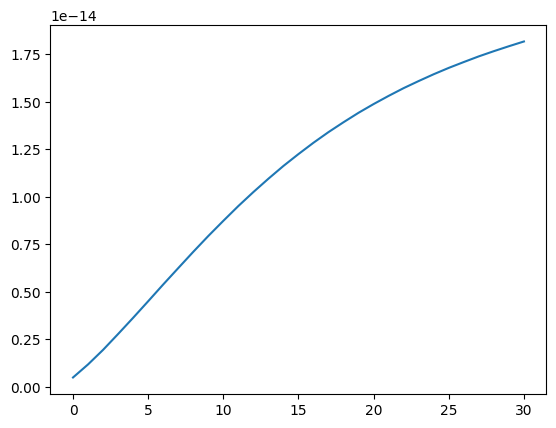

In [19]:
plt.plot(abs(np.array(u)))
#plt.gca().invert_yaxis()
plt.show()

In [109]:

punto=np.array([[9501,0]])
nlen=1

MG22=[]
u=[]
for i in range(len(f)):
  segmento, xp, ns=segmentos(L,dx[i])
  print('Numero de segmentos: %d'%ns)
  aux=np.zeros([int(ns),1])
  aux = aux + 0j*aux
  for n in range(nlen):
    #print('Punto: %d'%(n+1))
    aux2=0
    for l in range(int(ns)):
      #print('Segmento: %d'%l)
      #aux=Int_G22(n,l,k[i],segmento,punto,normal)
      #print(aux)
      #MG22.append(aux)
      #aux2=aux2+solucionG[i][l]*MG22[l]
      aux2=aux2+solucionG[i][l]*G22(k[i],segmento[l],punto,beta,rho)
      #aux2=aux2+solucionG[i][l]*Int_G22(n,l,k[i],segmento,punto,normal)
    u.append(aux2)
#print(MG22)
#print(len(MG22))
print(u)
print(len(u))



Numero de segmentos: 20
Numero de segmentos: 40
Numero de segmentos: 60
Numero de segmentos: 80
Numero de segmentos: 100
Numero de segmentos: 120
Numero de segmentos: 140
Numero de segmentos: 160
Numero de segmentos: 180
Numero de segmentos: 200
Numero de segmentos: 220
Numero de segmentos: 240
Numero de segmentos: 260
Numero de segmentos: 280
Numero de segmentos: 300
Numero de segmentos: 320
Numero de segmentos: 340
Numero de segmentos: 360
Numero de segmentos: 380
Numero de segmentos: 400
Numero de segmentos: 420
Numero de segmentos: 440
Numero de segmentos: 460
Numero de segmentos: 480
Numero de segmentos: 500
Numero de segmentos: 520
Numero de segmentos: 540
Numero de segmentos: 560
Numero de segmentos: 580
Numero de segmentos: 600
Numero de segmentos: 620
[array([-2.05743764e-16+7.93523518e-16j]), array([-3.98868481e-16-2.32167935e-15j]), array([2.34784095e-15+3.62891006e-15j]), array([-5.46320047e-15-3.72082752e-15j]), array([8.95856261e-15+1.82783257e-15j]), array([-1.16368218e-

In [21]:
u[27]

array([8.65477473e-13-8.35497773e-13j])

In [22]:
'''
#Separar arreglo por estaciones
E1=[]
E2=[]
for i in range(len(u)):
  if i%2==0:
    E1.append(u[i])
  else:
    E2.append(u[i])

E1A=np.array(E1)
E2A=np.array(E2)
prueba=E1A[::-1]
#print(E1A)
print(len(E1A))

plt.plot(f,abs(E1A),'*')
plt.gca().invert_yaxis()

plt.plot(f,abs(E2A),'-')

plt.show()
'''

"\n#Separar arreglo por estaciones\nE1=[]\nE2=[]\nfor i in range(len(u)):\n  if i%2==0:\n    E1.append(u[i])\n  else:\n    E2.append(u[i])\n\nE1A=np.array(E1)\nE2A=np.array(E2)\nprueba=E1A[::-1]\n#print(E1A)\nprint(len(E1A))\n\nplt.plot(f,abs(E1A),'*')\nplt.gca().invert_yaxis()\n\nplt.plot(f,abs(E2A),'-')\n\nplt.show()\n"

30


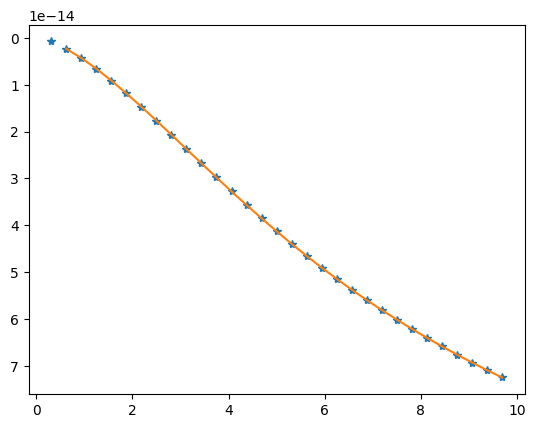

In [110]:
'''
#Sacando el conjugado:
E1Aconj=E1A.conjugate()
plt.plot(f,abs(E1A),'*')
E1AC=E1Aconj[1:]
print(len(E1AC))
plt.plot(f[1:],abs(E1AC))
plt.gca().invert_yaxis()

plt.show()
'''
u=np.array(u)
#Sacando el conjugado:
uconj=u.conjugate()
plt.plot(f,abs(u),'*')
uC=uconj[1:]
print(len(uC))
plt.plot(f[1:],abs(uC))
plt.gca().invert_yaxis()

plt.show()

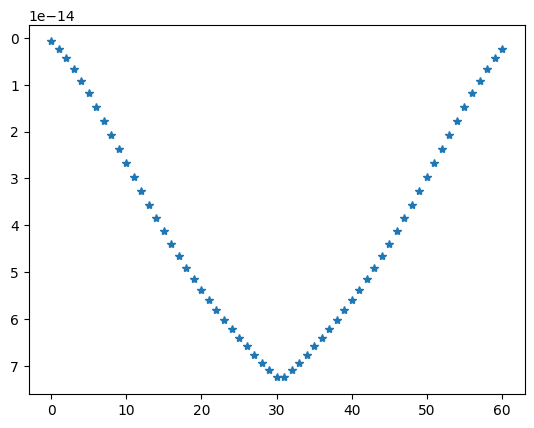

61

In [111]:
'''
#UNiendo arreglos:
E1C=E1AC[::-1]
E1F=np.concatenate((E1A,E1AC))

plt.plot(abs(E1F),'*')
plt.gca().invert_yaxis()
plt.show()
'''

#UNiendo arreglos:
uC2=uC[::-1]
uF=np.concatenate((u,uC2))

plt.plot(abs(uF),'*')
plt.gca().invert_yaxis()
plt.show()
len(uF)

In [25]:
'''
#Ricker Ivan
#def Ricker(dt,N):
tp=0.3
ts=0.5
N=len(f)*2
t=np.zeros(N)
r=np.zeros(N)
for i in range(N):
    t[i]=dt*i;
    a=np.pi*(t[i]-ts)/tp;
    a2=a*a;
    r[i]=(a2-1/2)*np.exp(-a2);
Fr=np.fft.fft(r)
#Fr=Fr[0:round(N/2)]
plt.plot(t,r)
plt.title("Espectro Ricker")
plt.show()

plt.plot(abs(Fr))
plt.show()
'''


'\n#Ricker Ivan\n#def Ricker(dt,N):\ntp=0.3\nts=0.5\nN=len(f)*2\nt=np.zeros(N)\nr=np.zeros(N)\nfor i in range(N):\n    t[i]=dt*i;\n    a=np.pi*(t[i]-ts)/tp;\n    a2=a*a;\n    r[i]=(a2-1/2)*np.exp(-a2);\nFr=np.fft.fft(r)\n#Fr=Fr[0:round(N/2)]\nplt.plot(t,r)\nplt.title("Espectro Ricker")\nplt.show()\n\nplt.plot(abs(Fr))\nplt.show()\n'

In [112]:
#Ricker Nuevo:
def ricker_wavelet(t, f):
    return (1 - 2 * (np.pi * f * (t-1))**2) * np.exp(-(np.pi * f * (t-1))**2)

61


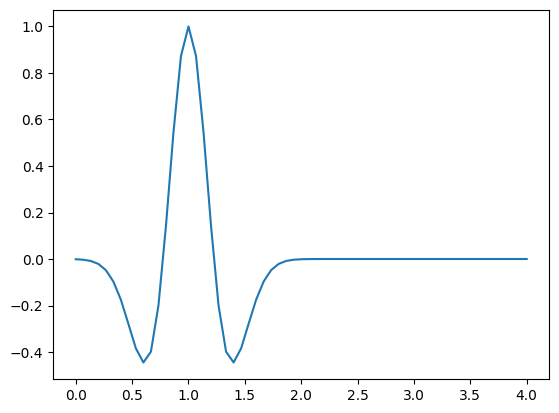

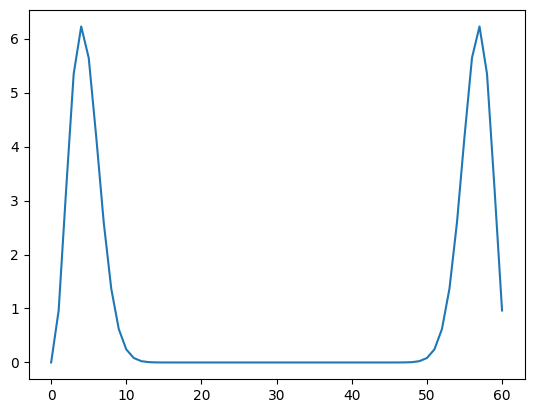

In [113]:
# Parámetros del pulso Ricker
frecuencia_ricker = 1.0  # Frecuencia central del pulso

# Crear un vector de tiempo para el pulso Ricker
t_ricker = np.linspace(0, 4, len(f)*2-1)

# Calcular el pulso Ricker
ricker = ricker_wavelet(t_ricker, frecuencia_ricker)
print(len(ricker))


plt.plot(t_ricker,ricker)
plt.show()


# Calcular la transformada de Fourier del pulso Ricker
ricker_frecuencias = np.fft.fft(ricker)
plt.plot(abs(ricker_frecuencias))
plt.show()
#plt.plot(abs(ricker_frecuencias))
#plt.show()

In [85]:
# Para ver que ambas señales tengan el mismo número de elementos
if len(ricker) < len(uF):
    ricker = np.pad(ricker, (0, len(uF) - len(ricker)))
elif len(ricker) > len(uF):
    uF = np.pad(uF, ((0, len(ricker) - len(uF)), (0, 0)))

In [29]:
'''
# Para ver que ambas señales tengan el mismo número de elementos
if len(ricker) < len(E1A):
    ricker = np.pad(ricker, (0, len(E1A) - len(ricker)))
elif len(ricker) > len(E1A):
    E1A = np.pad(E1A, ((0, len(ricker) - len(E1A)), (0, 0)))

print(len(E1A))

if len(ricker) < len(E2A):
    ricker = np.pad(ricker, (0, len(E2A) - len(ricker)))
elif len(ricker) > len(E2A):
    E2A = np.pad(E2A, ((0, len(ricker) - len(E2A)), (0, 0)))
'''

'\n# Para ver que ambas señales tengan el mismo número de elementos\nif len(ricker) < len(E1A):\n    ricker = np.pad(ricker, (0, len(E1A) - len(ricker)))\nelif len(ricker) > len(E1A):\n    E1A = np.pad(E1A, ((0, len(ricker) - len(E1A)), (0, 0)))\n\nprint(len(E1A))\n\nif len(ricker) < len(E2A):\n    ricker = np.pad(ricker, (0, len(E2A) - len(ricker)))\nelif len(ricker) > len(E2A):\n    E2A = np.pad(E2A, ((0, len(ricker) - len(E2A)), (0, 0)))\n'

In [30]:
#print(E1A)

61


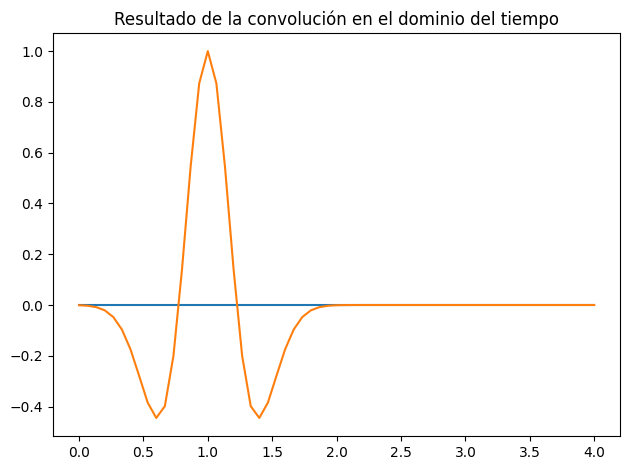

In [114]:
# Calcular la transformada de Fourier del pulso Ricker
#ricker_frecuencias = np.fft.fft(ricker)
#plt.plot(abs(ricker_frecuencias))
#plt.show()

# Realizar la convolución en el dominio de las frecuencias
resultado_frecuencias = uF * ricker_frecuencias[:, np.newaxis]
#resultado_frecuencias2 = E2A * ricker_frecuencias[:, np.newaxis]

# Calcular la transformada inversa de Fourier para obtener la señal en el dominio del tiempo
resultado_tiempo = np.fft.ifft(resultado_frecuencias, axis=0)
#resultado_tiempo2 = np.fft.ifft(resultado_frecuencias2, axis=0)
print(len(resultado_tiempo))

# Graficar el resultado en el dominio del tiempo
plt.plot(t_ricker,resultado_tiempo.real)
plt.plot(t_ricker,ricker)
#plt.plot(t_ricker,resultado_tiempo2.real,'*')
plt.title('Resultado de la convolución en el dominio del tiempo')
plt.tight_layout()
plt.show()

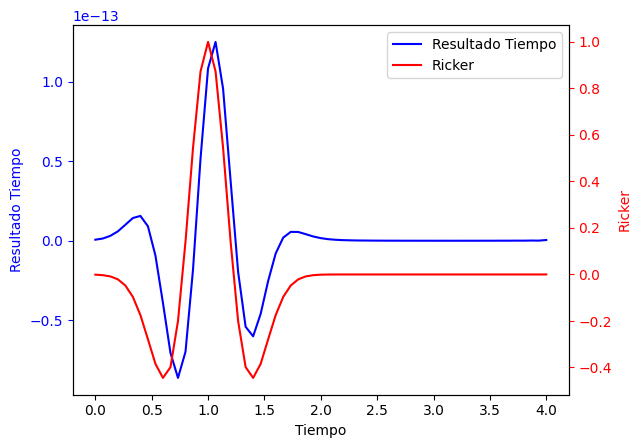

In [107]:
# Crear la primera gráfica
fig, ax1 = plt.subplots()
ax1.plot(t_ricker, resultado_tiempo.real, 'b-', label='Resultado Tiempo')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Resultado Tiempo', color='b')
ax1.tick_params('y', colors='b')

# Crear la segunda gráfica en los mismos ejes x
ax2 = ax1.twinx()
ax2.plot(t_ricker, ricker, 'r-', label='Ricker')
ax2.set_ylabel('Ricker', color='r')
ax2.tick_params('y', colors='r')

# Añadir leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Mostrar la gráfica
plt.show()

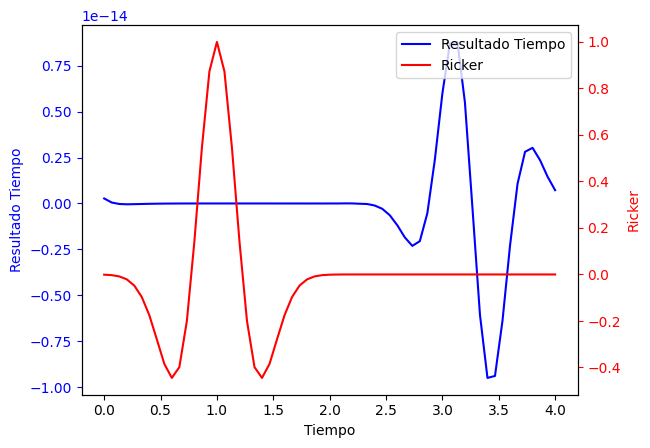

In [115]:
# Crear la primera gráfica
fig, ax1 = plt.subplots()
ax1.plot(t_ricker, resultado_tiempo.real, 'b-', label='Resultado Tiempo')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Resultado Tiempo', color='b')
ax1.tick_params('y', colors='b')

# Crear la segunda gráfica en los mismos ejes x
ax2 = ax1.twinx()
ax2.plot(t_ricker, ricker, 'r-', label='Ricker')
ax2.set_ylabel('Ricker', color='r')
ax2.tick_params('y', colors='r')

# Añadir leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Mostrar la gráfica
plt.show()

In [32]:
'''
plt.plot(abs(E1A))
plt.show()

print(abs(E1A[1]))
'''

'\nplt.plot(abs(E1A))\nplt.show()\n\nprint(abs(E1A[1]))\n'

In [33]:
#Convolución:
'''
print(len(Fr[0:31]))
print(len(E1A))

Fr=np.array(Fr)
E1A=np.array(E1A)

FINAL=[]
for i in range(len(Fr[0:31])):
  aux=Fr[i]*E1A[i]
  FINAL.append(aux)
FINAL=np.array(FINAL)
#print(FINAL)

plt.plot(FINAL)
plt.show()

final=np.fft.ifft(FINAL)
print(len(final))
plt.plot(np.fft.fftshift(np.abs(final)))
plt.show()
'''
'''
ConPrub=[]
for i in range(len(E1F)):
  aux=Fr[i]*E1F[i]
  ConPrub.append(aux)
print(len(ConPrub))
ConPrub=np.array(ConPrub)
TConPrub=np.fft.ifft(ConPrub)

print(ConPrub)
print(TConPrub)
'''

'\nConPrub=[]\nfor i in range(len(E1F)):\n  aux=Fr[i]*E1F[i]\n  ConPrub.append(aux)\nprint(len(ConPrub))\nConPrub=np.array(ConPrub)\nTConPrub=np.fft.ifft(ConPrub)\n\nprint(ConPrub)\nprint(TConPrub)\n'

In [34]:
'''
#Transformando a dominio de tiempo:
TOTALp=E1F*Fr
pruba= np.fft.ifft(TOTALp)
print(len(E1F))
print(len(Fr))
len(f)
'''

'\n#Transformando a dominio de tiempo:\nTOTALp=E1F*Fr\npruba= np.fft.ifft(TOTALp)\nprint(len(E1F))\nprint(len(Fr))\nlen(f)\n'

In [35]:
'''
def ricker_wavelet(t, f):
    """
    Función que calcula el pulso Ricker para el tiempo 't' y la frecuencia central 'f'.
    """
    A = (1.0 - 2.0 * (np.pi**2) * (f**2) * (t**2))
    B = np.exp(-(np.pi**2) * (f**2) * (t**2))
    return A * B

# Crear un arreglo de tiempo
t = np.linspace(-0.1, 0.1, 1000)  # Rango de tiempo

# Definir la frecuencia central del pulso Ricker
frecuencia_central = 20  # Puedes ajustar la frecuencia central según tus necesidades

# Calcular el pulso Ricker para el arreglo de tiempo dado
ricker = ricker_wavelet(t, frecuencia_central)

# Graficar el pulso Ricker
plt.figure(figsize=(8, 4))
plt.plot(t, ricker, label='Pulso Ricker')
plt.title('Pulso Ricker')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()
'''

'\ndef ricker_wavelet(t, f):\n    """\n    Función que calcula el pulso Ricker para el tiempo \'t\' y la frecuencia central \'f\'.\n    """\n    A = (1.0 - 2.0 * (np.pi**2) * (f**2) * (t**2))\n    B = np.exp(-(np.pi**2) * (f**2) * (t**2))\n    return A * B\n\n# Crear un arreglo de tiempo\nt = np.linspace(-0.1, 0.1, 1000)  # Rango de tiempo\n\n# Definir la frecuencia central del pulso Ricker\nfrecuencia_central = 20  # Puedes ajustar la frecuencia central según tus necesidades\n\n# Calcular el pulso Ricker para el arreglo de tiempo dado\nricker = ricker_wavelet(t, frecuencia_central)\n\n# Graficar el pulso Ricker\nplt.figure(figsize=(8, 4))\nplt.plot(t, ricker, label=\'Pulso Ricker\')\nplt.title(\'Pulso Ricker\')\nplt.xlabel(\'Tiempo\')\nplt.ylabel(\'Amplitud\')\nplt.legend()\nplt.grid(True)\nplt.show()\n'

In [36]:
#FALTA RICKER Y SU CONVOLUCION :O